# Part 2 – Aim: Practice the usage of CNN (Convolutional Neural Network). 

In [1]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
div_train = 0.5 #50% train 
div_valid_test = 0.5 #25% validation 25% test

# Choose directory
path_avi_home = 'C:/Users/avi/Desktop/Avi/PhD/Courses/Machine Learning - Lior Rockach/Exercises/3/data/'
path_avi_pc = 'C:/Users/avi5/Google Drive/PhD/Courses/Machine Learning - Lior Rockach/Exercises/3/data/'
path_avi_lap = 'C:/Users/avico/Google Drive/PhD/Courses/Machine Learning - Lior Rockach/Exercises/3/data/'
path_or_pc = 'C:/Users/orbitt/Desktop/שנה ד/סמסטר ב/למידה חישובית/hw_3/part 2/'

path = path_avi_home

## Model ##

We used a pre-trained model (self.net) within a class ClassifierModule. We defined that there is no need to update the weights for the pre-trained model. However, we added another layer to match the model to the number of classes (102) in our problem and trained it. So in the end of the day, we have been training only the last layer, and the other layers remain frozen.

More detailed explanations of the models we have chosen and the structure of the layers are attached in the pdf file 'Networks architecture.'

In [3]:
class ClassifierModule(nn.Module):
    def __init__(self, model, out_neurouns=1000, num_classes=102):
        super(ClassifierModule, self).__init__()
    
        self.net = model
        self.out1 = nn.Linear(out_neurouns, num_classes)
        
        for para in self.net.parameters():
            para.requires_grad = False

    def forward(self, x):
        
        x1 = self.net(x)
        y = self.out1(x1)

        return y

In [21]:
def get_accuracy(model, X, y, batch_size):
    pos = np.random.permutation(np.arange(X.shape[0]))
    batch_num = int(X.shape[0] / batch_size)
    
    correct = 0
    for batch_i in range(batch_num):
        
        i = batch_i * batch_size
        f = (batch_i + 1) * batch_size
        xt = X[pos[i:f], :, :, :].cuda()
        st = y[pos[i:f], :].flatten().cuda()
        probs = model(xt)
        
        y_pred = torch.nn.functional.softmax(probs, dim=1).argmax(dim=1)
        correct += torch.count_nonzero(y_pred == st)
    return int(correct) / X.shape[0]

In [5]:
def train(epochs, model, X_train, y_train, X_valid, y_valid,
          learning_rate, batch_size, weight_decay=0, checkpoint_path=None):
    
    iter_i = 0
    model.train()
    
    #choosing optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    batch_num = int(X_train.shape[0] / batch_size)

    for epoch_i in range(epochs):
        
        # shuffle the training set
        pos = np.random.permutation(np.arange(X_train.shape[0]))
        
        for batch_i in range(batch_num):
            
            i = batch_i * batch_size
            f = (batch_i + 1) * batch_size
            
            xt = X_train[pos[i:f], :, :, :].cuda()
            st = y_train[pos[i:f], :].flatten().cuda()
            
            y_pred = model(xt)    # compute prediction logit
        
            optimizer.zero_grad()         # a clean up step for PyTorch
    
            loss = criterion(y_pred, st)  # compute the total loss
            
            loss.backward()               # compute updates for each parameter
       
            optimizer.step()              # make the updates for each parameter
    
            # save the current training information
            iters.append(iter_i)
            losses.append(float(loss) / batch_size)  # compute *average* loss

            if not iter_i % batch_num: #print every epoch
            
                iters_sub.append(iter_i)
                train_acc = get_accuracy(model, X_train, y_train, batch_size)
                train_accs.append(train_acc)
                
                val_acc = get_accuracy(model, X_valid, y_valid, batch_size)
                val_accs.append(val_acc)
                
                print("Train Epoch: %d. Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%] [Loss %f]" % 
                      (epoch_i, iter_i, val_acc * 100, train_acc * 100, float(loss) / batch_size))

                if (checkpoint_path is not None) and iter_i > 0:
                    torch.save(model.state_dict(), checkpoint_path+str(epoch_i))


            iter_i += 1 # increment the iteration number
        
    return iters, losses, iters_sub, train_accs, val_accs

In [6]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.show()
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

## Pre-processing  ##

First, we matched the labels to the appropriate images according to the files on the attached website to the job requirements. Then, we created a pair of tensors, X and y, where X is a 3-dimensional tensor containing the RGB image's pixels and y has the labels, respectively.

Each trained model receives images of a specific size, so all images must be the same size. Unfortunately, we received the images in different sizes, so we used the resize function, which resizes the images to the desired size.

In addition, the trained model is trained on data that are normally distributed with expectation and variance with specific values:(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).

Therefore, we normalized our data according to the same parameters. Finally, we split the data to train test and valid.

In [7]:
def process_images(path, preprocess, width=224, height=224, random_state=1):
    imglabel_map = path + 'imagelabels.mat'
    setid_map = path + 'setid.mat'
    
    imagelabels = sio.loadmat(imglabel_map)['labels'][0]
    setids = sio.loadmat(setid_map)
    ids = np.concatenate([setids['trnid'][0], setids['valid'][0],setids['tstid'][0]])
    
    num_img = len(ids)   
    X = torch.zeros((num_img, 3, width, height), dtype=torch.float32)
    y = torch.zeros((num_img, 1), dtype=torch.int64) 
    
    for i in ids:
        path_i = os.path.join(path, 'jpg', 'image_{:05d}.jpg'.format(i))
        full_size_img = Image.open(path_i)
        X[i-1, :, :, :] = preprocess(full_size_img)
        y[i-1, :] = int(imagelabels[i-1])-1
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=div_train, random_state=random_state, stratify=y)  
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=div_valid_test,
                                                        random_state=random_state, stratify=y_temp)  
    del X_temp, y_temp
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [8]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
X_train, y_train, X_valid, y_valid, X_test, y_test = process_images(path, preprocess, random_state=10)

## Training  ##
Here, we trained the models with two seeds, meaning the train and test datasets were divided differently.
The hyperparameters were tuned before representing here.

Using cache found in C:\Users\avi/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0. Iter 0. [Val Acc 1%] [Train Acc 1%] [Loss 0.059781]
Train Epoch: 1. Iter 40. [Val Acc 8%] [Train Acc 11%] [Loss 0.039678]
Train Epoch: 2. Iter 80. [Val Acc 24%] [Train Acc 26%] [Loss 0.030776]
Train Epoch: 3. Iter 120. [Val Acc 36%] [Train Acc 40%] [Loss 0.027339]
Train Epoch: 4. Iter 160. [Val Acc 43%] [Train Acc 48%] [Loss 0.022493]
Train Epoch: 5. Iter 200. [Val Acc 47%] [Train Acc 53%] [Loss 0.021373]
Train Epoch: 6. Iter 240. [Val Acc 51%] [Train Acc 57%] [Loss 0.022807]
Train Epoch: 7. Iter 280. [Val Acc 56%] [Train Acc 61%] [Loss 0.018380]
Train Epoch: 8. Iter 320. [Val Acc 57%] [Train Acc 63%] [Loss 0.015435]
Train Epoch: 9. Iter 360. [Val Acc 61%] [Train Acc 66%] [Loss 0.013321]
Train Epoch: 10. Iter 400. [Val Acc 60%] [Train Acc 67%] [Loss 0.013735]
Train Epoch: 11. Iter 440. [Val Acc 61%] [Train Acc 68%] [Loss 0.014592]
Train Epoch: 12. Iter 480. [Val Acc 61%] [Train Acc 69%] [Loss 0.013478]
Train Epoch: 13. Iter 520. [Val Acc 65%] [Train Acc 71%] [Loss 0.012

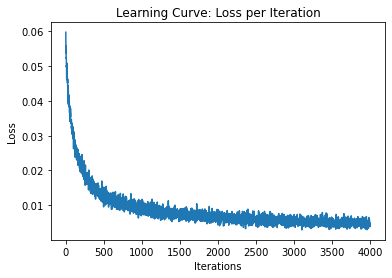

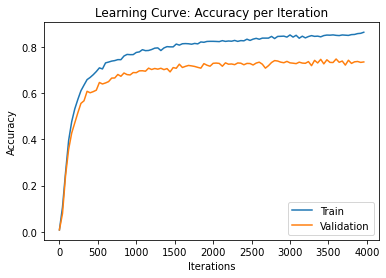

In [34]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
classifier_model = ClassifierModule(model).cuda()
iters, losses, iters_sub, train_accs, val_accs = train(100, classifier_model, X_train, y_train, X_valid, y_valid,
                                                       learning_rate=0.0001, batch_size=100, weight_decay=0.2, checkpoint_path=None)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

In [35]:
test_acc = get_accuracy(classifier_model, X_test, y_test, batch_size=100)
print('Accuracy of the test results:', np.round(test_acc * 100, 2))

Accuracy of the test results: 74.56


Using cache found in C:\Users\avi/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0. Iter 0. [Val Acc 2%] [Train Acc 3%] [Loss 0.053105]
Train Epoch: 1. Iter 40. [Val Acc 76%] [Train Acc 85%] [Loss 0.005213]
Train Epoch: 2. Iter 80. [Val Acc 81%] [Train Acc 92%] [Loss 0.003091]
Train Epoch: 3. Iter 120. [Val Acc 84%] [Train Acc 95%] [Loss 0.002188]
Train Epoch: 4. Iter 160. [Val Acc 84%] [Train Acc 96%] [Loss 0.001219]
Train Epoch: 5. Iter 200. [Val Acc 84%] [Train Acc 97%] [Loss 0.001213]
Train Epoch: 6. Iter 240. [Val Acc 84%] [Train Acc 97%] [Loss 0.000723]
Train Epoch: 7. Iter 280. [Val Acc 85%] [Train Acc 97%] [Loss 0.000484]
Train Epoch: 8. Iter 320. [Val Acc 85%] [Train Acc 97%] [Loss 0.000607]
Train Epoch: 9. Iter 360. [Val Acc 86%] [Train Acc 98%] [Loss 0.000432]
Train Epoch: 10. Iter 400. [Val Acc 86%] [Train Acc 98%] [Loss 0.000359]
Train Epoch: 11. Iter 440. [Val Acc 86%] [Train Acc 98%] [Loss 0.000240]
Train Epoch: 12. Iter 480. [Val Acc 85%] [Train Acc 98%] [Loss 0.000315]
Train Epoch: 13. Iter 520. [Val Acc 86%] [Train Acc 98%] [Loss 0.00

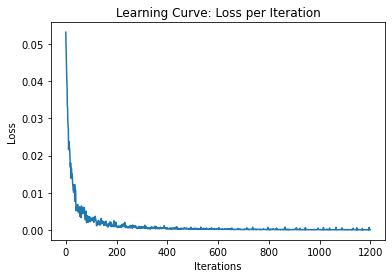

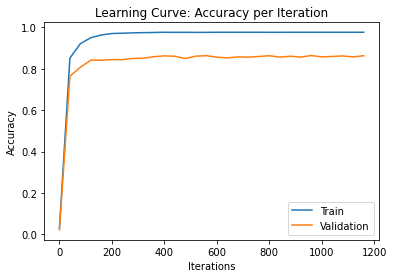

In [36]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
classifier_model = ClassifierModule(model).cuda()
iters, losses, iters_sub, train_accs, val_accs = train(30, classifier_model, X_train, y_train, X_valid, y_valid,
                                                       learning_rate=0.001, batch_size=100, weight_decay=0.4, checkpoint_path=None)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

In [37]:
test_acc = get_accuracy(classifier_model, X_test, y_test, batch_size=100)
print('Accuracy of the test results:', np.round(test_acc * 100, 2))

Accuracy of the test results: 87.35


In [38]:
del X_train, y_train, X_valid, y_valid, X_test, y_test
X_train, y_train, X_valid, y_valid, X_test, y_test = process_images(path, preprocess, random_state=20)

Using cache found in C:\Users\avi/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0. Iter 0. [Val Acc 1%] [Train Acc 1%] [Loss 0.055730]
Train Epoch: 1. Iter 40. [Val Acc 11%] [Train Acc 12%] [Loss 0.039721]
Train Epoch: 2. Iter 80. [Val Acc 27%] [Train Acc 27%] [Loss 0.032408]
Train Epoch: 3. Iter 120. [Val Acc 37%] [Train Acc 39%] [Loss 0.027135]
Train Epoch: 4. Iter 160. [Val Acc 45%] [Train Acc 48%] [Loss 0.021179]
Train Epoch: 5. Iter 200. [Val Acc 51%] [Train Acc 54%] [Loss 0.021399]
Train Epoch: 6. Iter 240. [Val Acc 54%] [Train Acc 59%] [Loss 0.018055]
Train Epoch: 7. Iter 280. [Val Acc 57%] [Train Acc 61%] [Loss 0.017156]
Train Epoch: 8. Iter 320. [Val Acc 58%] [Train Acc 63%] [Loss 0.015235]
Train Epoch: 9. Iter 360. [Val Acc 60%] [Train Acc 66%] [Loss 0.015838]
Train Epoch: 10. Iter 400. [Val Acc 62%] [Train Acc 67%] [Loss 0.014532]
Train Epoch: 11. Iter 440. [Val Acc 62%] [Train Acc 67%] [Loss 0.012986]
Train Epoch: 12. Iter 480. [Val Acc 64%] [Train Acc 70%] [Loss 0.015295]
Train Epoch: 13. Iter 520. [Val Acc 65%] [Train Acc 71%] [Loss 0.01

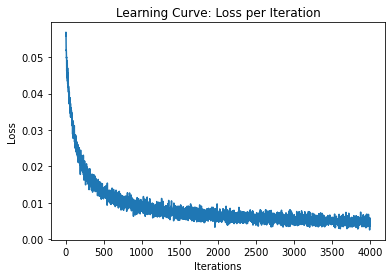

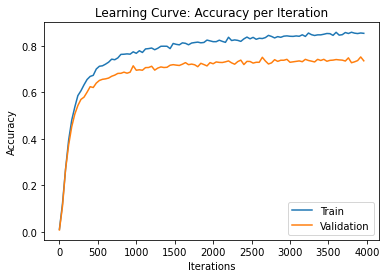

In [39]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)
classifier_model = ClassifierModule(model).cuda()
iters, losses, iters_sub, train_accs, val_accs = train(100, classifier_model, X_train, y_train, X_valid, y_valid,
                                                       learning_rate=0.0001, batch_size=100, weight_decay=0.2, checkpoint_path=None)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

In [40]:
test_acc = get_accuracy(classifier_model, X_test, y_test, batch_size=100)
print('Accuracy of the test results:', np.round(test_acc * 100, 2))

Accuracy of the test results: 73.44


Using cache found in C:\Users\avi/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0. Iter 0. [Val Acc 3%] [Train Acc 3%] [Loss 0.053968]
Train Epoch: 1. Iter 40. [Val Acc 79%] [Train Acc 86%] [Loss 0.006310]
Train Epoch: 2. Iter 80. [Val Acc 83%] [Train Acc 93%] [Loss 0.002328]
Train Epoch: 3. Iter 120. [Val Acc 84%] [Train Acc 95%] [Loss 0.001463]
Train Epoch: 4. Iter 160. [Val Acc 85%] [Train Acc 96%] [Loss 0.001478]
Train Epoch: 5. Iter 200. [Val Acc 85%] [Train Acc 97%] [Loss 0.001137]
Train Epoch: 6. Iter 240. [Val Acc 85%] [Train Acc 97%] [Loss 0.000770]
Train Epoch: 7. Iter 280. [Val Acc 87%] [Train Acc 97%] [Loss 0.001023]
Train Epoch: 8. Iter 320. [Val Acc 86%] [Train Acc 98%] [Loss 0.000491]
Train Epoch: 9. Iter 360. [Val Acc 87%] [Train Acc 98%] [Loss 0.000336]
Train Epoch: 10. Iter 400. [Val Acc 86%] [Train Acc 98%] [Loss 0.000259]
Train Epoch: 11. Iter 440. [Val Acc 87%] [Train Acc 98%] [Loss 0.000272]
Train Epoch: 12. Iter 480. [Val Acc 87%] [Train Acc 98%] [Loss 0.000179]
Train Epoch: 13. Iter 520. [Val Acc 87%] [Train Acc 98%] [Loss 0.00

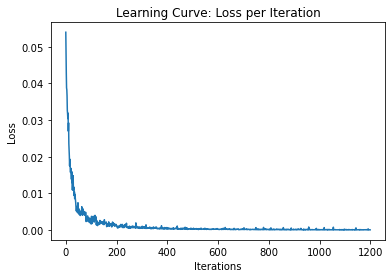

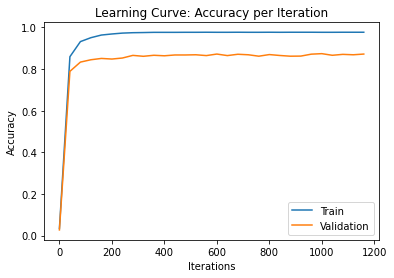

In [41]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
classifier_model = ClassifierModule(model).cuda()
iters, losses, iters_sub, train_accs, val_accs = train(30, classifier_model, X_train, y_train, X_valid, y_valid,
                                                       learning_rate=0.001, batch_size=100, weight_decay=0.4, checkpoint_path=None)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

In [42]:
test_acc = get_accuracy(classifier_model, X_test, y_test, batch_size=100)
print('Accuracy of the test results:', np.round(test_acc * 100, 2))

Accuracy of the test results: 85.89
